In [860]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from sortedcontainers import SortedDict

In [1009]:
# For convenience I use a class for rectangles, it would make sense to define draw methods and such here
class Rect:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.x1 = x+w
        self.y1 = y+h
    def __repr__(self):
        return str((self.x, self.x1, self.y, self.y1))

In [1010]:
# Global parameters

rng = np.random.default_rng() # random number generator
viewport_width = 100
viewport_height = 300

# after selecting a top left corner, we check how much space there is below that corner.
# so we need a "bottom line" which is located at some big number that we'll never reach
max_scroll = 1<<30

# random rectangles will be generated with that width and height on average (could split in two variables if we want different averages)
avg_img_width = viewport_width/3

# standard deviation from the average width for the generated rectangles
std_dev = viewport_width/12

# rectangles will have this width at minimum when getting generated
# if there's less space than that to the right of a top left corner,
# the rectangle to the left or top of that corner will be extended instead of generating a new one
min_img_width = viewport_width/8
# same with height
min_img_height = min_img_width

# when padding the rectangles to leave some space between them, minimum padding
min_pad = 1
# average padding
avg_pad = min_pad * 2

In [1011]:
# Convenience method that resets everything to its initial state
def reset():
    global vlines_left, vlines_right, hlines_top, hlines_bottom, top_left_corners, corners_set, rects
    
    # Each of those 4 is a sorted dictionary. The keys are the horizontal (or vertical) positions of lines
    # The values are the list of rectangle ids which have a line at that position
    # The keys are always ordered and searchable in O(log(n)). Insertion is also O(log(n))
    # For instance if vlines_left = {10: [3], 20: [1, 2]} that means that the rectangle with id 3 has
    # its left line at position x=10, and rectangles with ids 1 and 2 have their left line at position x=20
    vlines_left = SortedDict()
    vlines_right = SortedDict()
    hlines_top = SortedDict()
    hlines_bottom = SortedDict()
    
    # rects is the global dictionary with every rectangle added. Keys are the rectangle id and values are Rect objects (defined above)
    rects = {}
    
    # Initially we add 4 rectangles corresponding to the 4 sides of the drawable area.
    # For instance the top of the viewport (y=0) is the bottom line of some rectangle starting at y=-1 above and of height 1
    # We use negative ids to remember that these rectangles shouldn't be drawn
    
    # Add rectangle to the right of the viewport
    add_rect(-1, Rect(viewport_width, 0, 1, max_scroll))
    
    # Add rectangle to the left of the viewport
    add_rect(-2, Rect(-1, 0, 1, max_scroll))
    
    # Add rectangle to the top of the viewport
    add_rect(-3, Rect(0, -1, viewport_width, 1))
    
    # Add rectangle to the bottom of the max scrollable area
    add_rect(-4, Rect(0, max_scroll, viewport_width, 1))
    
    # top_left_corners is the list of every "top left corner" which have a rectangle vertical right line to their left
    # and a rectangle horizontal bottom line to their top
    # format: (x, y, top_rectangle_id, left_rectangle_id)
    # Initially contains the top left corner of the viewport at (0, 0) surrounded by rectangle -3 to the top and -2 to the left
    top_left_corners = [(0, 0, -3, -2)]
reset()

In [1012]:
# Adds a rectangle "nr" (new rectangle) with id rect_id to the global list of rectangles
# Updates the list of top left corners and sorted lists of lines accordingly
def add_rect(rect_id, nr):
    rects[rect_id] = nr
    
    if nr.x in vlines_right:
        for rid in vlines_right[nr.x]:
            if rects[rid].y <= nr.y1 < rects[rid].y1: # the new left line ends in the middle of a right line
                top_left_corners.append((nr.x, nr.y1, rect_id, rid))
                break

    if nr.x1 in vlines_left:
        for rid in vlines_left[nr.x1]:
            if nr.y <= rects[rid].y1 < nr.y1: # the new right line contains the end of a left line
                top_left_corners.append((nr.x1, rects[rid].y1, rid, rect_id))
                break

    if nr.y in hlines_bottom:
        for rid in hlines_bottom[nr.y]:
            if rects[rid].x <= nr.x1 < rects[rid].x1: # the new top line ends in the middle of a bottom line
                top_left_corners.append((nr.x1, nr.y, rid, rect_id))
                break

    if nr.y1 in hlines_top:
        for rid in hlines_top[nr.y1]:
            if nr.x <= rects[rid].x1 < nr.x1: # the new bottom line contains the end of a top line
                top_left_corners.append((rects[rid].x1, nr.y1, rect_id, rid))
                break

    if nr.x in vlines_left:
        vlines_left[nr.x].append(rect_id)
    else:
        vlines_left[nr.x] = [rect_id]
    if nr.x1 in vlines_right:
        vlines_right[nr.x1].append(rect_id)
    else:
        vlines_right[nr.x1] = [rect_id]
        
    if nr.y in hlines_top:
        hlines_top[nr.y].append(rect_id)
    else:
        hlines_top[nr.y] = [rect_id]
    if nr.y1 in hlines_bottom:
        hlines_bottom[nr.y1].append(rect_id)
    else:
        hlines_bottom[nr.y1] = [rect_id]

# Extends the rectangle with id rid by dx to the right and dy to the bottom
# Updates the list of top left corners and sorted lists of lines accordingly
def extend_rect(rid, dx=0, dy=0):
    r = rects[rid]
    if dx != 0:
        vlines_right[r.x1].remove(rid)
        r.x1 += dx
        r.w += dx
        
        # After we've moved that right line, we have to check if it overlaps with a left line
        # of a different rectangle, which would create a new top left corner
        if r.x1 in vlines_left:
            for lid in vlines_left[r.x1]:
                if r.y <= rects[lid].y1 < r.y1: # the new right line contains the end of a left line
                    top_left_corners.append((r.x1, rects[lid].y1, lid, rid))
                    break
        
        # We also check if the extended bottom line created a new top left corner by overlapping with a top line
        if r.y1 in hlines_top:
            for tid in hlines_top[r.y1]:
                if r.x1 - dx <= rects[tid].x1 < r.x1: # the extended bottom line contains the end of a top line
                    top_left_corners.append((rects[tid].x1, r.y1, rid, tid))
                    break

        if r.x1 in vlines_right:
            vlines_right[r.x1].append(rid)
        else:
            vlines_right[r.x1] = [rid]
    if dy != 0:
        hlines_bottom[r.y1].remove(rid)
        r.y1 += dy
        r.h += dy
        
        # After we've moved that bottom line, we have to check if it overlaps with a top line
        # of a different rectangle, which would create a new top left corner
        if r.y1 in hlines_top:
            for tid in hlines_top[r.y1]:
                if r.x <= rects[tid].x1 < r.x1: # the new bottom line contains the end of a top line
                    top_left_corners.append((rects[tid].x1, r.y1, rid, tid))
                    break

        # We also check if the extended right line created a new top left corner by overlapping with a left line
        if r.x1 in vlines_left:
            for lid in vlines_left[r.x1]:
                if r.y1 - dy <= rects[lid].y1 < r.y1: # the extended right line contains the end of a left line
                    top_left_corners.append((r.x1, rects[lid].y1, lid, rid))
                    break

        if r.y1 in hlines_bottom:
            hlines_bottom[r.y1].append(rid)
        else:
            hlines_bottom[r.y1] = [rid]
        

In [1013]:
# Calling loop will pick a random available top left corner and add a new rectangle
# of random size in that corner with id rect_id
# If there is not enough space to fit a rectangle of min_width and min_height,
# will instead extend either the left or top rectangle of that corner
def loop(rect_id):
    global top_left_corners
    
    # We want to keep track of corner that are below the viewport (in case the user scrolls) but we should not pick them here
    # since there's no point generating a rectangle that the user will not see yet
    viewable_corners = list(filter(lambda c: c[1] < viewport_height, top_left_corners))
    if len(viewable_corners) == 0:
        return
    
    # Pick a random viewable top left corner uniformly randomly
    corner_index = random.randint(0, len(viewable_corners) - 1)
    corner = viewable_corners.pop(corner_index)
    
    # Remove that corner from the original top_left_corner list. Note that due to the way the code works, the same corner
    # can be in that list multiple times, so we make sure to remove every instance in the list, not just the first one
    top_left_corners = list(filter(lambda c: c != corner, top_left_corners))
    
    # Define some variables for the properties of that corner for convenience
    # topid is the id of the rectangle to the top of that corner
    # leftid is the id of the rectangle to the left of that corner
    x, y, topid, leftid = corner

    # Go through every left vertical line to the right of "x" until one contains "y"
    found = False
    for lx in vlines_left.irange(minimum=x):
        rids = vlines_left[lx]
        for rid in rids:
            r = rects[rid]
            if r.y <= y < r.y1:
                max_x = r.x
                found = True
                break
        if found:
            break
    # Go through every top horizontal line to the bottom of "y" until one contains "x"
    found = False
    for ty in hlines_top.irange(minimum=y):
        rids = hlines_top[ty]
        for rid in rids:
            r = rects[rid]
            if r.x <= x < r.x1:
                max_y = r.y
                found = True
                break
        if found:
            break

    # If there's not enough space to fit a rectangle, we're going to find a neighbor (top or left) rectangle to extend instead
    if max_x - x < min_img_width or max_y - y < min_img_height:
        # check if the rectangle to the left of the top left corner could be extended
        rleft = rects[leftid]
        if rleft.y >= y and rleft.y1 <= max_y:
            extend_rect(leftid, dx=max_x - x)
            
            return corner, rleft

        # if the left rectangle couldn't be extended, check if the rectangle to the top of the top left corner could be extended
        rtop = rects[topid]
        if rtop.x >= x and rtop.x1 <= max_x:
            extend_rect(topid, dy=max_y - y)
            
            return corner, rtop
    
    # Now we know that we can fit a new rectangle in the selected top left corner
    # Randomly pick where that rectangle will end, using a Gaussian (normal) distribution
    width = int(min(max_x - x, max(min_img_width, rng.normal(avg_img_width, std_dev))))
    height = int(min(max_y - y, max(min_img_height, rng.normal(avg_img_width, std_dev))))
    
    nr = Rect(x, y, width, height)
    add_rect(rect_id, nr)
    return corner, nr

def get_padrects(pad=False):
    # Returns a randomly padded version of the rectangles (to leave some space between them)
    padrects = []
    for rid, r in rects.items():
        if rid < 0:
            continue
        if pad:
            pads = np.maximum(min_pad, rng.normal(avg_pad, avg_pad/3, 4))
        else:
            pads = [0, 0, 0, 0]
        padrects.append([(r.x+pads[0], r.y+pads[1]), r.w-pads[0]-pads[2], r.h-pads[1]-pads[3]])
    return padrects

def drawfill(corner=None, rect=None, pad=False):
    # Draws the current state. If corner and rect are provided, the corresponding rectangle
    # will be highlighted and all top left corners will be highlighted (for debugging)
    padrects = get_padrects(pad=pad)
    plt_rects = [Rectangle(*r) for r in padrects]
    pc = PatchCollection(plt_rects, facecolor='green', alpha=0.5,
                         edgecolor='blue')
    plt.figure(figsize=(5, 5))
    plt.xlim(0, viewport_width)
    plt.ylim(0, viewport_height)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()
    ax.add_collection(pc)
    if corner:
        ax.add_collection(PatchCollection([Rectangle((rect.x, rect.y), rect.w, rect.h)], edgecolor='red', alpha=0.5, linewidth=2, facecolor=None))
        plt.scatter([x for (x,_,_,_) in top_left_corners], [y for (_,y,_,_) in top_left_corners], marker='o', color='yellow')


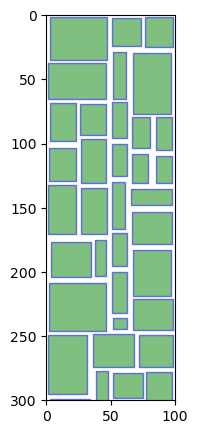

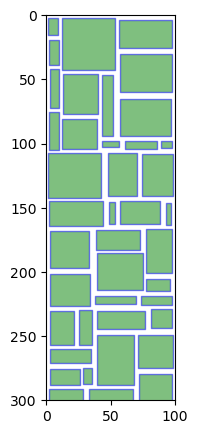

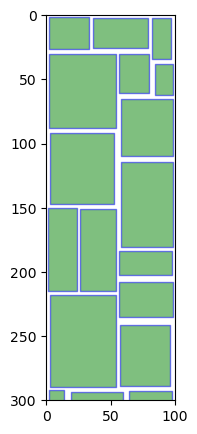

In [1014]:
reset()
avg_img_width = viewport_width/3
std_dev = viewport_width/12
min_img_width = viewport_width/8
min_img_height = min_img_width
for i in range(150):
    loop(i)
drawfill(pad=True)

reset()
avg_img_width = viewport_width/3
std_dev = viewport_width/12
min_img_width = viewport_width/12
min_img_height = min_img_width
for i in range(150):
    loop(i)
drawfill(pad=True)

reset()
avg_img_width = viewport_width/2.5
std_dev = viewport_width/6
min_img_width = viewport_width/6
min_img_height = min_img_width
for i in range(150):
    loop(i)
drawfill(pad=True)


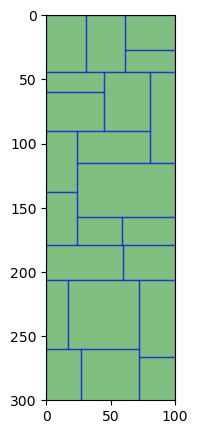

In [1006]:
drawfill()